In [1]:
# Load FrameWork and Layer module

import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np

## Seq2Seq with Attention

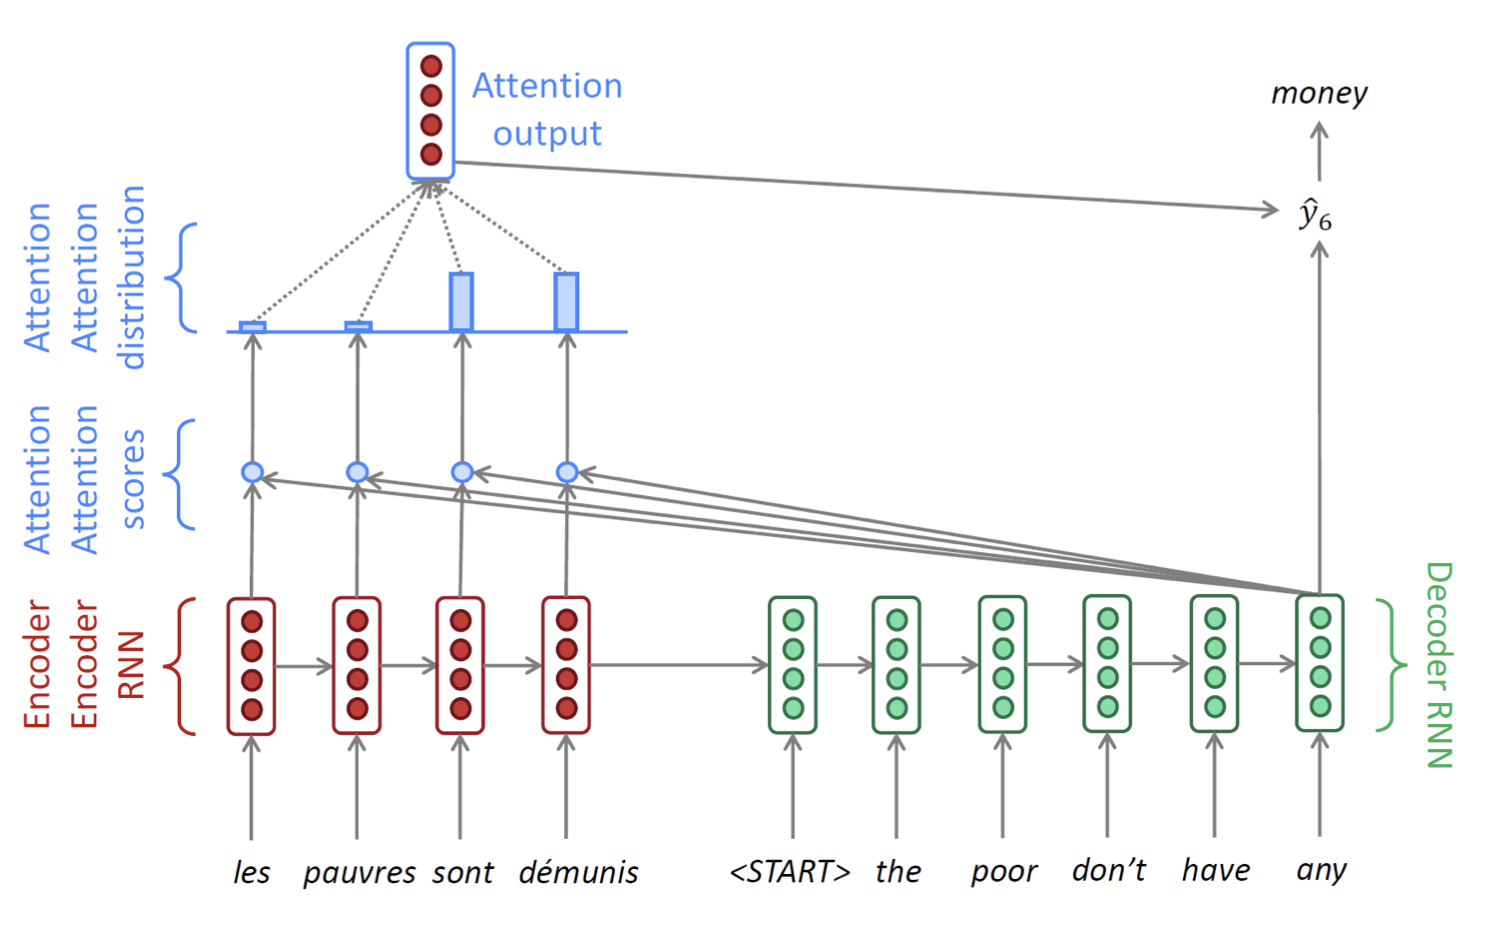

In [2]:
## Making Word2Index for tokenize

def Make_Word2Index(ctxt : list):
  word2index = dict()
  words = []
  if type(ctxt) == list:
    for text in ctxt:
      for word in text.split(" "):
        words.append(word)
  else :
    for word in ctxt.split(" "):
      words.append(word)

### word2index need <sos> and <eos> tokens
  word2index['<sos>'] = 0
  word2index['<eos>'] = 1
  for index, word in enumerate(list(set(words))):
    word2index[word] = index+2

  return word2index

## Tokenize function  
def tokenize(text, word2index): # -> input = text, word2index from above function
  tokens = []
  for word in text.split(" "):
    tokens.append(word2index[word])

  return tokens

In [3]:
""" Do Tokenizing """

## ctxt Example
ctxt = [
              '신은 항상 우리가 하는 말을 듣고 있다 따라서 마음속으로 하는 혼잣말에도 주의하라',
              '가장 귀중한 사랑의 가치는 희생과 헌신이다',
              '양초는 남을 밝게 해 주며 자신을 소비한다',
              '하루에 3시간을 걸으면 7년 후에 지구를 한바퀴 돌 수 있다',
              '먼저핀꽃은 먼저진다 남보다 먼저 공을 세우려고 조급히 서둘것이 아니다'
]
## Make word2index
word2index = Make_Word2Index(ctxt)

src =  ctxt[3]
tgt = '<sos> '+ ctxt[3] + ' <eos>'
## Tokenizing text
src = tokenize(src, word2index)
tgt = tokenize(tgt, word2index)

## List needs to be transformed into LongTensor for calculating Embedding, Not FloatTensor
src = torch.LongTensor([src])
tgt = torch.LongTensor([tgt])

print("--- Before embedding ---")
# print("text :", ctxt[3])
print("Size of src : ", src.size())
# print("input :\n", src)
print("Size of tgt : ", tgt.size())
# print("output :\n", tgt)

--- Before embedding ---
Size of src :  torch.Size([1, 10])
Size of tgt :  torch.Size([1, 12])


In [4]:
""" Init State """

### Default Setting
h_dim = 128  # hidden_dimension
input_size = len(word2index)  # Dimension of input meaning size of word2index
output_size = len(word2index)
emb_dim = 64

### Word Embedding with embedding layer
embedder_encoder = nn.Embedding(input_size, emb_dim)  # input : (batch_size, sequence_length) -> output : (batch_size, sequence_length, embedding_dim)
embedder_decoder = nn.Embedding(output_size, emb_dim)  # input : (batch_size, sequence_length) -> output : (batch_size, sequence_length, embedding_dim)

input = embedder_encoder(src)
output = embedder_decoder(tgt)

print("--- After embedding ---")
print("size of input :",input.size())
# print("input :\n",input)
print("size of output :",output.size())
# print("output :\n",output)

--- After embedding ---
size of input : torch.Size([1, 10, 64])
size of output : torch.Size([1, 12, 64])


In [5]:
""" Make Encoder(LSTM) and Calculate Context Vector"""

### Use previously created LSTM
lstm_encoder = nn.LSTM(input_size = emb_dim, hidden_size = h_dim, batch_first = True)  # input : (batch_size, sequence_length, embedding_dim) 

### After Make LSTM Start Encode and Make Context vector
### last_hidden_state and last_cell_state are context vector after Encoder
all_hidden_state_encoder, (hidden_state_encoder, cell_state_encoder) = lstm_encoder(input)

#all_hidden_state_encoder = torch.cat(all_hidden_state_encoder , dim =1)

print("size of all_hidden_state :", all_hidden_state_encoder.size())
print("all_hidden_state :\n",all_hidden_state_encoder)

size of all_hidden_state : torch.Size([1, 10, 128])
all_hidden_state :
 tensor([[[-0.0603, -0.1406, -0.0165,  ..., -0.0348,  0.1020, -0.0389],
         [-0.0022,  0.1549, -0.1542,  ..., -0.1043,  0.1338,  0.0322],
         [-0.0757, -0.0077,  0.0447,  ..., -0.0297,  0.1490,  0.0161],
         ...,
         [-0.0574, -0.1186, -0.1493,  ..., -0.1105,  0.0169, -0.2325],
         [ 0.0527,  0.1314, -0.0994,  ..., -0.0743,  0.0919, -0.2849],
         [ 0.1001, -0.0723,  0.1246,  ..., -0.1748, -0.0299, -0.1391]]],
       grad_fn=<TransposeBackward0>)


In [6]:
""" Make Decoder(LSTM) and Calculate First Sequence"""

### Use previously created LSTM
lstm_decoder = nn.LSTM(input_size = emb_dim, hidden_size = h_dim, batch_first = True)  ### input : (batch_size, sequence_length, hidden_dim) 
fc = nn.Linear(h_dim, output_size)
### Calculate First Decoder layer 
input_decoder = output[:,0,:].unsqueeze(1) ### First Decoder input is '<sos>' token which is first token of tgt
result, (hidden_state, cell_state) = lstm_decoder(input_decoder, (hidden_state_encoder, cell_state_encoder))
result = fc(result)

print("size of result :",result.size())
print("result :\n",result)
print("size of hidden_state :",hidden_state.size())
print("hidden_state :\n",hidden_state)

size of result : torch.Size([1, 1, 44])
result :
 tensor([[[-0.0333, -0.0197, -0.0563, -0.0996, -0.1200,  0.0255,  0.1085,
          -0.0680, -0.0035,  0.0449, -0.0161, -0.1329,  0.0726, -0.0814,
           0.1788, -0.0081,  0.0214, -0.0868, -0.0174,  0.0983, -0.0437,
          -0.0626, -0.0150, -0.0409,  0.0789,  0.1621, -0.1056, -0.0689,
           0.0226, -0.0521, -0.0226,  0.0570,  0.0577, -0.1550, -0.0536,
           0.1269, -0.0910,  0.1066, -0.0301, -0.1129,  0.0089,  0.1569,
          -0.0267, -0.2154]]], grad_fn=<AddBackward0>)
size of hidden_state : torch.Size([1, 1, 128])
hidden_state :
 tensor([[[ 0.0784, -0.0027, -0.0245, -0.2573,  0.0158,  0.0605,  0.1498,
           0.0475,  0.1283,  0.0154, -0.0228,  0.2609, -0.2109, -0.1682,
           0.1368, -0.0292, -0.0817,  0.0471,  0.0872,  0.0176,  0.1376,
          -0.0216, -0.0271, -0.0524, -0.1483, -0.0442, -0.0521, -0.0890,
           0.0134,  0.1489,  0.0601, -0.0217, -0.1070, -0.0210,  0.1142,
          -0.0600, -0.0758,  